# Excercise 1: Using generative models as priors in Bayesian inference problems

For many problems in statistical image analysis, we are interested in recovering an image of interest, $x \in \mathbb{R}^d$, from a set of measurements $y \in \mathbb{R}^n$.

We consider linear Gaussian measurement models of the form 
$$y = Ax + w,$$ where $A \in \mathbb{R}^{n \times d}$ is a linear operator and $w \sim N(0, \sigma^2 I_d)$ is a noise term.  Here, we study the case where both $A$ and $\sigma^2 \in \mathbb{R}$ are known.  The recovery of x from y is often ill posed or ill conditioned, so we regularize the estimation problem by incorporating prior information.

The measurement model defines a likelihood function $p(y|x)$.  To define a prior, we use a generative model, namely a pre-trained Variational Autoencoder (VAE).

## Very Brief Introduction to Generative Models

Let $\{x_1, ..., x_N\}$ be a large training dataset of clean data, which we assume to be i.i.d. samples from a data generating distribution $\mu$.  Generative models (such as GANs, VAEs and Flow-based models) aim to learn an approximation $\mu_\theta$ of this distribution from the training data, parametrised by a neural network $f_\theta$.

Many such models have the following structure:
1. A latent variable $z$ is defined, with distribution $\nu_z$ and density $p_z$. This distribution is usually chosen to be simple to sample, *e.g.*, $z \sim N(0, I)$.
2. $\mu_\theta$ is defined as the $f_\theta$-pushforward of $\nu_z$, *i.e.*
$$
\mu_\theta(A) = \nu_z(f_\theta^{-1}(A))
$$
for all measurable sets $A$.
3. The neural network $f_\theta$ is then trained to minimise some measure of discrepancy between $\mu_\theta$ and the training data.

By sampling $\{z_i\}_i$ according to $\nu_z$, and taking $\{x_i = f_\theta(z_i) \}_i$, we can thus generate samples from $\mu_\theta$.  This is the basic framework of highly publicised models such as StyleGAN ([thispersondoesnotexist.com](https://www.thispersondoesnotexist.com)).

In this exercise, we use the learnt distribution $\mu_\theta$ as a prior in inverse problems. This exercise is based on Holden et al. (2022) https://arxiv.org/abs/2103.10182, except that Bayesian computation is performed by using an unadjusted Langevin algorithm instead of a parallel tempering Metropolis-Hasting algorithm.

## Defining a prior using a VAE

For VAEs, the latent variable, $z$ is chosen to have lower dimensionality than the variable of interest $x$.  This means $\mu_\theta$ does not define a density w.r.t. the Lebesgue measure.  The typical Bayesian update

$$
p_\theta(x|y) \propto p(y|x) p_\theta(x)
$$

is therefore not possible, since $p(x)$ is not defined.

However, Bayesian analysis is made possible by working directly with the latent variable $z$.  The posterior density $p_\theta(z|y)$ is given by

$$
p_\theta(z|y) \propto p(y|x=f_\theta(z)) p_z(z)\\
= p_\theta(y|z) p_z(z).
$$

This distribution can then be sampled to generate $\{z_i\}_i$ according to $p_\theta(z|y)$.  Taking $x_i = f_\theta(z_i)$, we therefore generate samples $\{x_i\}$ from the posterior distribution of $x|y$.



\


\

In this exercise, we will use the Unadjusted Langevin Algorithm (ULA) to sample this distribution in order to perform Monte Carlo estimation.

## Getting Started

To begin, we clone the github repository where the pretrained network is stored, and load the required packages.

In [ ]:
%cd /content
!git clone https://github.com/MathematicalImagingEdinburgh/ColabExercises.git
%cd ColabTutorials/Bayesian Imaging with VAE prior

/content
Cloning into 'ColabTutorials'...
remote: Enumerating objects: 100, done.
remote: Counting objects: 100% (100/100), done.
remote: Compressing objects: 100% (89/89), done.
remote: Total 100 (delta 21), reused 62 (delta 8), pack-reused 0
Receiving objects: 100% (100/100), 36.07 MiB | 12.55 MiB/s, done.
Resolving deltas: 100% (21/21), done.
/content/ColabTutorials/Bayesian Imaging with VAE prior


In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from utils import *
from vae import *
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
!pip install kornia
import kornia

def imshow(x):
  plt.figure()
  plt.imshow(x[0,0].detach().cpu().numpy(), cmap="gray")
  plt.axis("off")


device = "cpu"

     |████████████████████████████████| 493 kB 4.3 MB/s 


## Load an MNIST digit as the "true" unknown image $x$, and generate the observed data $y$ by degrading $x$ by applying a degradation filter and some additive noise.


We will apply this methodology to the MNIST dataset of handwritten images.

### Set $x$ to a randomly selected element of the MNIST dataset

In [ ]:
batch_size = 1
test_loader = DataLoader(
                    datasets.MNIST('data', train=False, download=True, transform=transforms.ToTensor()),
                    batch_size=batch_size, shuffle=True)

x_true = next(iter(test_loader))[0].to(device).detach()

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



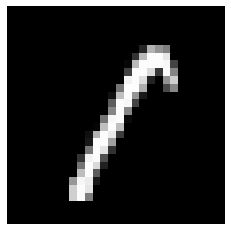

In [ ]:
imshow(x_true)

### Generate observed data $y$ from $x$ by applying the observation model

We now define a measurement model, and generate observation $y$.

In this case, $A$ will be a linear operator applying a [box blur](https://en.wikipedia.org/wiki/Box_blur) of size 9 by 9, and we set $\sigma=0.1$.

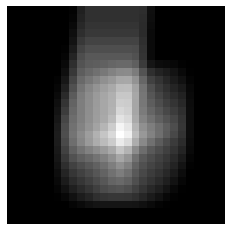

In [ ]:
A = lambda x: kornia.filters.box_blur(x, (9,9))

Ax = A(x_true)
imshow(Ax)

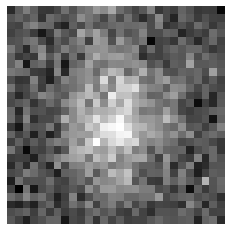

In [ ]:
sigma = 0.1
y = Ax + sigma * torch.randn_like(Ax)

imshow(y)

## Defining the Prior

The prior is defined by a Variational Autoencoder pretrained on the MNIST dataset.

The VAE used here has a latent dimensionality of 12, and assigns the latent variable a standard normal distribution.

**Task 1.1:** Load the pretrained VAE, e.g., using the code
```
vaefc = load_vae_model('FullyConnected', device=device)
f_theta = lambda z: vaefc.decoder(z)[0]
```
and generate some (e.g., 4) samples from the prior distribution to check that the model has been correctly loaded. 

Recall:
To sample the prior, we first generate $z_i$ according to the distribution $p_z(z)$, then apply the VAE to generate $x_i = f_\theta(z_i)$

In [ ]:
# Add your code here

## Sample Posterior Distribution using an Unadjusted Langevin Algorithm (ULA)

To sample $p_\theta(z|y)$ using ULA it is necessary to calculate the gradient of $U = -\log p_\theta(z|y)$ with respect to $z$.

This can be performed using autodifferentiation, using the **grad()** function within the **torch.autograd** automatic differentiation package, *e.g.*,

```
U = -log_posterior(z)
dUdz = torch.autograd.grad(U, z)
```

**Task 1.2:** To implement ULA, write a function **log_posterior()** which, given input $z$ (additional arguments can be used) computes $\log p_\theta(z|y)$ (up to proportionality) according to Bayes' rule.

In [ ]:
def log_prior(z):

# Add your code here

def log_likelihood(x, y, sigma):

# Add your code here

def log_posterior(z, y, A, sigma, f_theta):

# Add your code here

**Task 1.3:** Now write a function **ULA()** that, given an initial $z_0$, performs $N$ iterations of ULA with a step size $\delta$ and a burn-in period of $N_0$ iterations.  The function should return the samples $\{z_1,...,z_N\}$ targeting $p_\theta(z|y)$ (up to the discretisation bias of ULA).

In [ ]:
def ULA(z0, y, A, sigma, f_theta, niter, step_size, burnin):
# Add your code here

**Task 1.4:** Execute ULA to generate $N=10^5$ samples, with a step size of $\delta = 0.001$ and a burn-in period of $N_0 = 10^3$ iterations.

In [ ]:
# Add your code here

**Task 1.5:** Store $\log p_\theta(z_i|y)$ for each iteration $i$. Plot this statistic against $i$.  Does the Markov chain appear to have reached stationarity?

In [ ]:
# Add your code here

**Task 1.6:** Using these samples from $\log p_\theta(z|y)$, estimate the posterior mean, after discarding the samples obtained before the chain has reached stationarity.

Compute the [PSNR](https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio) of the posterior mean estimate with respect to the true image.  In this case, where the true image has a maximum intensity of 1, the PSNR (in dB) is given by:

$$
PSNR(y, x) = -10 \log_{10} MSE(y, x)
$$

Note that a higher PSNR indicates a higher fidelity reconstruction of the true image.

\

**Task 1.7:** How does changing $\sigma$ and the size of the blur kernel affect the PSNR of the resulting Bayesian estimator? Discuss your results.

In [ ]:
# Add your code here

### Principal Component Analysis

A principal component analysis can be performed in order to help better understand the covariance structure of the posterior distribution.  This can be performed using **PCA** from **sklearn.decomposition** (imported in preamble).  The package documentations is available [here](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html).

**Task 1.8:** Perform PCA on the posterior samples of $z|y$ generated above.  Find and display the eigenvectors corresponding to the first 2 principal components.  

**Task 1.9:** Explore how the estimated images change as you move in the direction of these eigenvalues. Briefly discuss your results.

An example is given below illustrating how the estimated images change along the first 2 dimensions of the prior distribution on $z$.

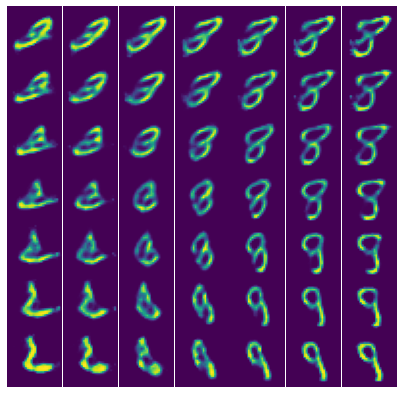

In [ ]:
vaefc = load_vae_model('FullyConnected', device=device)
f_theta = lambda z: vaefc.decoder(z)[0]

z_mean = torch.zeros((1, latent_dim), device=device)

eig0 = torch.zeros((1, latent_dim), device=device)
eig0[:,0] = 1

eig1 = torch.zeros((1, latent_dim), device=device)
eig1[:,1] = 1

nplots = 7
fig, ax = plt.subplots(nplots, nplots, figsize=(nplots,nplots))

plt.subplots_adjust(wspace=0, hspace=0)
[axi.set_axis_off() for axi in ax.ravel()]

ks = np.linspace(-3,3,nplots)
for i in range(nplots):
  for j in range(nplots):
    k0 = ks[i]
    k1 = ks[j]
    ax[i,j].imshow(f_theta(z_mean + k0 * eig0 + k1 * eig1)[0,0].detach().cpu().numpy())

In [ ]:
# Add core here for Tasks 1.8 and 1.9